#### This notebook describes:

#### 1) How the input for the CellChat analysis was created from the scRNAseq data

#### 2) How the CellChat processing was run separately for IPF and Control

# Cell-cell and cell-ligant analysis

This notebook is based on CellChat vignette:
https://github.com/sqjin/CellChat <br/>


## load environment

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import rcParams
import matplotlib.pyplot as plt

In [ ]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [1]:
# R 4.1.0 : Biocondutor 3.13 : Python 3.9.5 

In [4]:
# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [ ]:
%%R
library(CellChat)

In [4]:
%%R
options(bitmapType='cairo')

## load R libraries

if CellChat not installed then: `devtools::install_github("sqjin/CellChat")`

In [ ]:
%%R
library(CellChat)
library(patchwork)
library(scater)
library(tidyverse)
library(cowplot)
library(Matrix.utils)
library(dplyr)
library(magrittr)
library(Matrix)
library(purrr)
library(reshape2)
library(S4Vectors)
library(tibble)
library(RColorBrewer)
library(openxlsx)
options(stringsAsFactors = FALSE)
library(NMF)
library(ggalluvial)

## Set the ligand-receptor interaction database

CellChatDB:
- manually curated database of literature-supported ligand-receptor interactions in both human and mouse
- in mouse contains 2,021 validated molecular interactions, including:
    - 60% of secrete autocrine/paracrine signaling interactions
    - 21% of extracellular matrix (ECM)-receptor interactions
    - 19% of cell-cell contact interactions
- in human contains 1,939 validated molecular interactions, including:
    - 61.8% of paracrine/autocrine signaling interactions
    - 21.7% of extracellular matrix (ECM)-receptor interactions
    - 16.5% of cell-cell contact interactions.

CellChatDB can be updated by adding custom curated ligand-receptor pairs. The tutorial on how to do it is available in CellChat main repository.

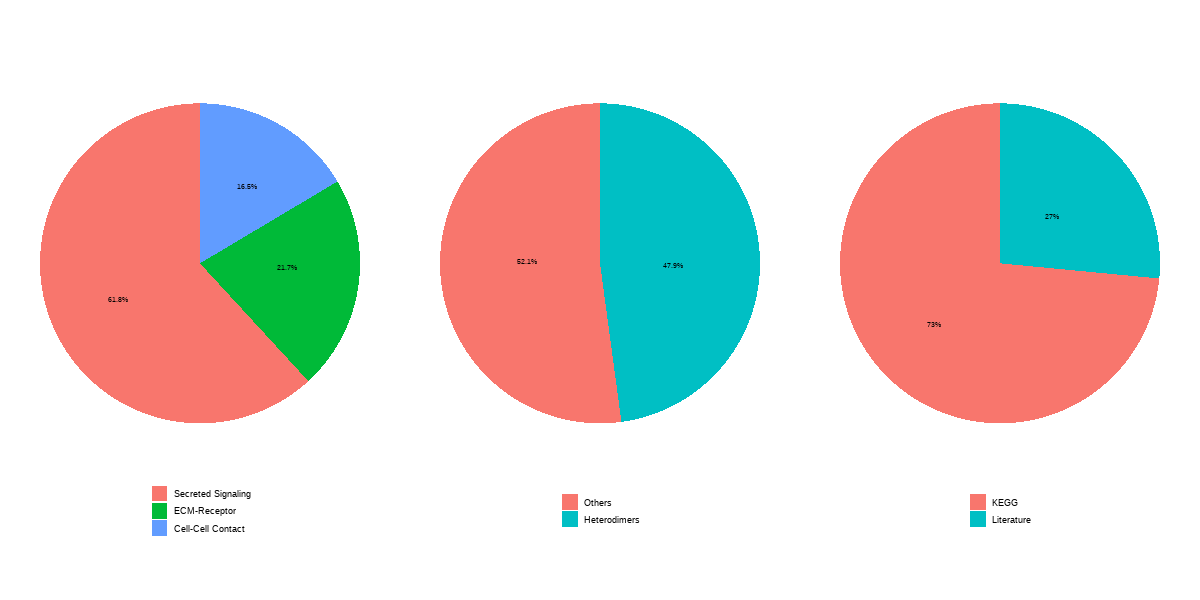

In [6]:
%%R -w 1200 -h 600
# use CellChatDB.human if running on human data
CellChatDB <- CellChatDB.human 
showDatabaseCategory(CellChatDB)

In [7]:
%%R
str(CellChatDB$geneInfo)

'data.frame':	41787 obs. of  6 variables:
 $ Symbol         : chr  "A1BG" "A1BG-AS1" "A1CF" "A2M" ...
 $ Name           : chr  "alpha-1-B glycoprotein" "A1BG antisense RNA 1" "APOBEC1 complementation factor" "alpha-2-macroglobulin" ...
 $ EntrezGene.ID  : int  1 503538 29974 2 144571 144568 NA NA 3 127550 ...
 $ Ensembl.Gene.ID: chr  "ENSG00000121410" "ENSG00000268895" "ENSG00000148584" "ENSG00000175899" ...
 $ MGI.ID         : chr  "MGI:2152878" "" "MGI:1917115" "MGI:2449119" ...
 $ Gene.group.name: chr  "Immunoglobulin like domain containing" "Antisense RNAs" "RNA binding motif containing" "C3 and PZP like, alpha-2-macroglobulin domain containing" ...


In [8]:
%%R
# Show the structure of the database
dplyr::glimpse(CellChatDB$interaction)

Rows: 1,939
Columns: 11
$ interaction_name   <chr> "TGFB1_TGFBR1_TGFBR2", "TGFB2_TGFBR1_TGFBR2", "TGFB…
$ pathway_name       <chr> "TGFb", "TGFb", "TGFb", "TGFb", "TGFb", "TGFb", "TG…
$ ligand             <chr> "TGFB1", "TGFB2", "TGFB3", "TGFB1", "TGFB1", "TGFB2…
$ receptor           <chr> "TGFbR1_R2", "TGFbR1_R2", "TGFbR1_R2", "ACVR1B_TGFb…
$ agonist            <chr> "TGFb agonist", "TGFb agonist", "TGFb agonist", "TG…
$ antagonist         <chr> "TGFb antagonist", "TGFb antagonist", "TGFb antagon…
$ co_A_receptor      <chr> "", "", "", "", "", "", "", "", "", "", "", "", "",…
$ co_I_receptor      <chr> "TGFb inhibition receptor", "TGFb inhibition recept…
$ evidence           <chr> "KEGG: hsa04350", "KEGG: hsa04350", "KEGG: hsa04350…
$ annotation         <chr> "Secreted Signaling", "Secreted Signaling", "Secret…
$ interaction_name_2 <chr> "TGFB1 - (TGFBR1+TGFBR2)", "TGFB2 - (TGFBR1+TGFBR2)…


In [9]:
%%R -o gene_key
gene_key <- CellChatDB$geneInfo

## Cell-chat analysis

### Create a CellChat object

CellChat object can be generated from:
1. a data matrix, 
2. Seurat 
3. SingleCellExperiment (SCE) object.

Data matrix for the gene expression data matrix formatting:
- genes should be in rows with their names as rownames 
- cells should be used in columns with colnames

Generally, normalized data (e.g., library-size normalization folowed by log-transformed with a pseudocount of 1) is required as input for CellChat analysis. \
<br/>
**Strongly advisable: use raw count input data**\
<br/>
If count data is provided:
- use `normalizeData` function to account for library size and then do log-transformed
- for the cell group information, provide a dataframe with rownames (required as input for CellChat)
<br/>
**Please note:**
- if using Seurat or SCE object, the meta data in the object will be used by default 
- for Seurat and SCE `group.by` must be provided to define the cell groups. e.g, `group.by = “ident”` for the default cell identities in Seurat object.

### Format count matrix

for ensembl gene id please use:

In [12]:
adata = sc.read_h5ad(".h5ad")

In [13]:
adata

AnnData object with n_obs × n_vars = 206947 × 30647
    obs: 'sampleID', 'study', 'diagnosis', 'Disease_study', 'compartment', 'cell type', 'cell subtype', 'n_genes', 'log1p_n_genes_by_counts', 'total_counts', 'pct_counts_mitochondrial', 'Source', 'n_genes_by_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'log1p_total_counts_mitochondrial', 'cell_type_CM', 'cell_type_CM2'
    var: 'gene_ids', 'gene_name', 'mitochondrial', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell subtype_colors', 'cell type_colors', 'cell_type_CM2_colors', 'cell_type_CM_colors', 'compartment_colors', 'diagnosis_colors', 'neighbors', 'study_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts', 'log1p'
    obsp: 'connectivities', 'distances'

In [14]:
adata.var

,gene_ids,gene_name,mitochondrial,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
ENSG00000243485,ENSG00000243485,RP11-34P13.3,False,64,0.004586,0.004576,99.978023,1.335534e+03,7.197835
ENSG00000237613,ENSG00000237613,FAM138A,False,12,0.000775,0.000775,99.995879,2.258354e+02,5.424225
ENSG00000186092,ENSG00000186092,OR4F5,False,38,0.002558,0.002554,99.986951,7.448303e+02,6.614498
ENSG00000238009,ENSG00000238009,RP11-34P13.7,False,2422,0.197062,0.179870,99.168309,5.738715e+04,10.957593
ENSG00000239906,ENSG00000239906,RP11-34P13.14,False,4,0.000181,0.000181,99.998626,5.262234e+01,3.981966
...,...,...,...,...,...,...,...,...,...
ENSG00000276345,ENSG00000276345,AC004556.1,False,46462,3.659548,1.538918,84.045410,1.065712e+06,13.879154
ENSG00000277856,ENSG00000277856,AC233755.2,False,62,0.009259,0.009216,99.978710,2.696299e+03,7.900006
ENSG00000275063,ENSG00000275063,AC233755.1,False,120,0.012317,0.012242,99.958793,3.586823e+03,8.185301
ENSG00000271254,ENSG00000271254,AC240274.1,False,17702,1.243489,0.808032,93.921309,3.621213e+05,12.799737


In [15]:
adata.var["ensembl_id"] = adata.var_names

In [16]:
adata.var_names = adata.var["gene_name"].tolist().copy()

In [17]:
adata.var

,gene_ids,gene_name,mitochondrial,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,ensembl_id
RP11-34P13.3,ENSG00000243485,RP11-34P13.3,False,64,0.004586,0.004576,99.978023,1.335534e+03,7.197835,ENSG00000243485
FAM138A,ENSG00000237613,FAM138A,False,12,0.000775,0.000775,99.995879,2.258354e+02,5.424225,ENSG00000237613
OR4F5,ENSG00000186092,OR4F5,False,38,0.002558,0.002554,99.986951,7.448303e+02,6.614498,ENSG00000186092
RP11-34P13.7,ENSG00000238009,RP11-34P13.7,False,2422,0.197062,0.179870,99.168309,5.738715e+04,10.957593,ENSG00000238009
RP11-34P13.14,ENSG00000239906,RP11-34P13.14,False,4,0.000181,0.000181,99.998626,5.262234e+01,3.981966,ENSG00000239906
...,...,...,...,...,...,...,...,...,...,...
AC004556.1,ENSG00000276345,AC004556.1,False,46462,3.659548,1.538918,84.045410,1.065712e+06,13.879154,ENSG00000276345
AC233755.2,ENSG00000277856,AC233755.2,False,62,0.009259,0.009216,99.978710,2.696299e+03,7.900006,ENSG00000277856
AC233755.1,ENSG00000275063,AC233755.1,False,120,0.012317,0.012242,99.958793,3.586823e+03,8.185301,ENSG00000275063
AC240274.1,ENSG00000271254,AC240274.1,False,17702,1.243489,0.808032,93.921309,3.621213e+05,12.799737,ENSG00000271254


In [18]:
adata.obs["diagnosis"].cat.categories

Index(['Control', 'IPF'], dtype='object')

In [19]:
# extract the counts and metadata for enriched dataset as simple variables for R
counts = adata.layers["counts"].toarray()
#counts = adata.layers['counts']
metadata = adata.obs.copy()
features = adata.var.copy()
features_orig = adata.var.copy()

#### Generate the gene key that is compatible with CellChat

In [20]:
gene_key = gene_key[['Symbol', 'Ensembl.Gene.ID']]
gene_key = (
    gene_key[gene_key['Ensembl.Gene.ID'].str.startswith('ENS')]
    .assign(ensembl_id = lambda x: x['Ensembl.Gene.ID']) 
    .set_index('ensembl_id')
)
gene_key = gene_key[['Symbol']].drop_duplicates()
gene_key

,Symbol
ensembl_id,
ENSG00000121410,A1BG
ENSG00000268895,A1BG-AS1
ENSG00000148584,A1CF
ENSG00000175899,A2M
ENSG00000245105,A2M-AS1
...,...
ENSG00000162378,ZYG11B
ENSG00000159840,ZYX
ENSG00000274572,ZYXP1


#### CellChat annotate features df

In [21]:
features = (
    features
    .join(gene_key, on = 'ensembl_id')
    .assign(gene_id = lambda x: x.index.copy())
    .reset_index()
    .assign(gene_test = lambda x: [True if x.loc[i, 'gene_id'] == x.loc[i, 'Symbol'] else False for i in list(x.index)])
    .assign(
        cellchat_symbol = lambda x: 
        [x.loc[i, 'Symbol'] if (x.loc[i, 'gene_test'] == False) & (pd.notnull(x.loc[i,'Symbol'])) else x.loc[i, 'gene_id'] for i in list(x.index)]
    )
)

#### Test if the result complements current annotation

In [22]:
features[(features.gene_test == False) & (features.Symbol.notnull())][['gene_test', 'Symbol','gene_id', 'cellchat_symbol']]

,gene_test,Symbol,gene_id,cellchat_symbol
0,False,MIR1302-2HG,RP11-34P13.3,MIR1302-2HG
9,False,LINC01409,RP11-206L10.9,LINC01409
13,False,LINC02593,RP11-54O7.3,LINC02593
35,False,C1QTNF12,FAM132A,C1QTNF12
38,False,LINC01786,RP5-902P8.10,LINC01786
...,...,...,...,...
30546,False,LRRC3-DT,LRRC3-AS1,LRRC3-DT
30549,False,LINC02575,AP001065.15,LINC02575
30570,False,PICSAR,LINC00162,PICSAR
30584,False,LINC01694,AL133493.2,LINC01694


In [23]:
features.shape, adata.var.shape

((30647, 15), (30647, 10))

Fix the duplicates in CellChat compatible gene names

In [24]:
duplicated_entries = list(set([x for x in features.cellchat_symbol.tolist() if features.cellchat_symbol.tolist().count(x) > 1]))

In [25]:
features[features.cellchat_symbol.isin(duplicated_entries)]

,index,gene_ids,gene_name,mitochondrial,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,ensembl_id,Symbol,gene_id,gene_test,cellchat_symbol
20490,LINC00383,ENSG00000237534,LINC00383,False,99,0.007526,0.007498,99.966004,2191.605957,7.692846,ENSG00000237534,NaN,LINC00383,False,LINC00383
20491,RP11-459J23.1,ENSG00000235221,RP11-459J23.1,False,2,0.000216,0.000216,99.999313,62.913731,4.157534,ENSG00000235221,LINC00383,RP11-459J23.1,False,LINC00383
21740,MEG8,ENSG00000258399,MEG8,False,1951,0.240080,0.215176,99.330046,69914.585938,11.155044,ENSG00000258399,NaN,MEG8,False,MEG8
21741,SNHG23,ENSG00000225746,SNHG23,False,6618,0.484419,0.395024,97.727444,141069.734375,11.857017,ENSG00000225746,MEG8,SNHG23,False,MEG8
24701,TBC1D26,ENSG00000255104,TBC1D26,False,406,0.034706,0.034118,99.860584,10106.986328,9.221081,ENSG00000255104,NaN,TBC1D26,False,TBC1D26
24702,TBC1D26-1,ENSG00000214946,TBC1D26-1,False,27,0.002043,0.002040,99.990728,594.813293,6.389927,ENSG00000214946,TBC1D26,TBC1D26-1,False,TBC1D26
28376,LINC00904,ENSG00000271649,LINC00904,False,65,0.005226,0.005213,99.977680,1521.972534,7.328419,ENSG00000271649,NaN,LINC00904,False,LINC00904
28378,CTC-523E23.15,ENSG00000271171,CTC-523E23.15,False,0,0.000000,0.000000,100.000000,0.000000,0.000000,ENSG00000271171,LINC00904,CTC-523E23.15,False,LINC00904


Manually changing the gene ids

In [26]:
row_num = [20490, 21740, 24701, 28376]
for i in row_num:
    features.loc[row_num, 'cellchat_symbol'] = features.loc[row_num, 'cellchat_symbol'] + '.1'

In [27]:
features[features.cellchat_symbol.isin(duplicated_entries)]

,index,gene_ids,gene_name,mitochondrial,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,ensembl_id,Symbol,gene_id,gene_test,cellchat_symbol
20491,RP11-459J23.1,ENSG00000235221,RP11-459J23.1,False,2,0.000216,0.000216,99.999313,62.913731,4.157534,ENSG00000235221,LINC00383,RP11-459J23.1,False,LINC00383
21741,SNHG23,ENSG00000225746,SNHG23,False,6618,0.484419,0.395024,97.727444,141069.734375,11.857017,ENSG00000225746,MEG8,SNHG23,False,MEG8
24702,TBC1D26-1,ENSG00000214946,TBC1D26-1,False,27,0.002043,0.002040,99.990728,594.813293,6.389927,ENSG00000214946,TBC1D26,TBC1D26-1,False,TBC1D26
28378,CTC-523E23.15,ENSG00000271171,CTC-523E23.15,False,0,0.000000,0.000000,100.000000,0.000000,0.000000,ENSG00000271171,LINC00904,CTC-523E23.15,False,LINC00904


In [28]:
features.shape, adata.var.shape

((30647, 15), (30647, 10))

In [29]:
for i in row_num:
    print(features.loc[i, 'ensembl_id'] == features_orig.reset_index().loc[i, 'ensembl_id'])

True
True
True
True


## generate input data frame for CellChat

In [31]:
%R -i metadata -i features

In [32]:
%reset_selective -f adata

In [33]:
%R -i counts

In [35]:
%reset_selective -f counts

In [36]:
%%R
dim(counts)

[1] 206947  30647


In [37]:
%%R
dim(features)

[1] 30647    15


In [38]:
%%R
dim(metadata)

[1] 206947     18


In [39]:
%%R
str(features)

'data.frame':	30647 obs. of  15 variables:
 $ index                : chr  "RP11-34P13.3" "FAM138A" "OR4F5" "RP11-34P13.7" ...
 $ gene_ids             : chr  "ENSG00000243485" "ENSG00000237613" "ENSG00000186092" "ENSG00000238009" ...
 $ gene_name            : chr  "RP11-34P13.3" "FAM138A" "OR4F5" "RP11-34P13.7" ...
 $ mitochondrial        : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ n_cells_by_counts    : int  64 12 38 2422 4 159 57 1 121 4704 ...
 $ mean_counts          : num  0.004586 0.000775 0.002558 0.197062 0.000181 ...
 $ log1p_mean_counts    : num  0.004576 0.000775 0.002554 0.17987 0.000181 ...
 $ pct_dropout_by_counts: num  100 100 100 99.2 100 ...
 $ total_counts         : num  1335.5 225.8 744.8 57387.2 52.6 ...
 $ log1p_total_counts   : num  7.2 5.42 6.61 10.96 3.98 ...
 $ ensembl_id           : chr  "ENSG00000243485" "ENSG00000237613" "ENSG00000186092" "ENSG00000238009" ...
 $ Symbol               : chr  "MIR1302-2HG" "FAM138A" "OR4F5" NA ...
 $ gene_id              

In [40]:
%%R

# format counts matrix to parse it into CellChat
input_df <- as.data.frame(t(counts))
colnames(input_df) <- rownames(metadata)
rownames(input_df) <- features$cellchat_symbol
    
# do.log: whether do log transformation with pseudocount 1
input_df <- CellChat::normalizeData(
    input_df,
    scale.factor = 10000, 
    do.log = TRUE
)

In [42]:
%%R
str(input_df)

 num [1:30647, 1:206947] 0 0 0 0 0 0 0 0 0 0 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:30647] "MIR1302-2HG" "FAM138A" "OR4F5" "RP11-34P13.7" ...
  ..$ : chr [1:206947] "AAACCTGAGTAGCGGT-1_4-SC56NOR-Morse" "AAAGATGGTAGGCTGA-1_4-SC56NOR-Morse" "AACCATGCATCCTAGA-1_4-SC56NOR-Morse" "AACTCAGGTACCGTTA-1_4-SC56NOR-Morse" ...


In [43]:
%%R
saveRDS(input_df, file = "input_df.rds")

### generate subset cellchat object per replicate and treatment type

In [45]:
%%R
metadata %>%
    dplyr::select(
            diagnosis,
                 ) %>% 
    unique()

                                      diagnosis
AAACCTGAGTAGCGGT-1_4-SC56NOR-Morse      Control
AAAGATGCACCGGAAA-1_9-SC87IPFLOW-Morse       IPF


In [46]:
%%R
# set the global conditions for CellChat analysis
condition_id = 'Control'

Parameter list elements:
1. conditions to compare
2. replicate columns in metadata
3. all other filtering parameters for every additional condition ther should only be a single element

In [47]:
%%R

parameter_list <- list(
    diagnosis = c("Control", "IPF")
)
parameter_list

$diagnosis
[1] "Control" "IPF"    



In [48]:
%%R

get_condition_list <- function(parameter_list) {
    condition_list <- list()
    parameter_df <- purrr::cross_df(parameter_list) %>% as.data.frame()
    for (row_num in seq_len(nrow(parameter_df))) {

        condition_vec <- vector()

        for (col_name in colnames(parameter_df)) {

            condition_vec <- base::append(condition_vec, parameter_df[row_num, col_name])

        }

        names(condition_vec) <- colnames(parameter_df)    
        condition_list[[row_num]] <- condition_vec
        names(condition_list)[row_num] <- paste0(condition_vec, collapse = "_")

    }

    return(condition_list)
}

In [49]:
%%R

get_cell_ids <- function(
    parameter_vec, # change to vector
    metadata_df = metadata
){
    # Extract unique cell ids from metadata data frame for an experiment with:
    # - multiple treatment conditions
    # - sample processing methods
    #
    # Input:
    # parameter_vec: named list containing conditions to keep and the instruction to split the data
    # metadata_df: data.frame; data frame object with unique cell ids as row names that contains treatment and enrichment columns 
    
    parameter_list <- split(unname(parameter_vec), names(parameter_vec))
                            
    if ( all(names(parameter_list) %in% colnames(metadata_df))) {
     
        message("Provided metadata conditions are present in the data set")
        
        dummy_df <- metadata_df
        
        for (param in names(parameter_list)) {
            
            dummy_df <- dummy_df[(dummy_df[[param]] %in% parameter_list[[param]]), ]            
            
        }
                
        cell_id <- rownames(dummy_df)
        
        return(cell_id)
                
    } else {
        
        stop('Metadata data frame incorrectly formatted. Treminating.')
             
    }    
            
}

In [50]:
%%R
get_cellchat_obj <- function(
    parameter_vec,
    metadata_df,
    input_df
) {
    
    cell_id <- get_cell_ids(parameter_vec, metadata_df)
    data_input <- input_df[, cell_id]
    meta_data <- metadata_df[cell_id, ]
    
    # If the number of labels and the factors do not match, it needs to be corrected
    meta_data$`cell_type_CM2` <- droplevels(meta_data$`cell_type_CM2`)
    
    cellchat <- createCellChat(
        object = data_input, 
        meta = meta_data, 
        group.by = "cell_type_CM2"
    )
    
    cellchat <- addMeta(cellchat, meta = meta_data)

    # set "cell_type_CM2" as default cell identity
    cellchat <- setIdent(cellchat, ident.use = "cell_type_CM2") 

    # show factor levels of the cell labels
    levels(cellchat@idents) 

    # number of cells in each cell group
    groupSize <- as.numeric(table(cellchat@idents))
    
    # use a subset of CellChatDB for cell-cell communication analysis
    # CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling") 

    # to use all CellChatDB for cell-cell communication analysis simply use the default CellChatDB
    CellChatDB.use <- CellChatDB

    # set the used database in the object
    cellchat@DB <- CellChatDB.use
    
    # subset the expression data of signaling genes for saving computation cost
    # This step is necessary even if using the whole database    
    cellchat <- subsetData(cellchat)
    #future::plan("multiprocess", workers = 16)
    cellchat <- identifyOverExpressedGenes(cellchat)
    cellchat <- identifyOverExpressedInteractions(cellchat)

    ## project gene expression data onto PPI network (optional)
    cellchat <- projectData(cellchat, PPI.human)
    
    cellchat <- computeCommunProb(cellchat)
    # Filter out the cell-cell communication if there are only few number of cells in certain cell groups
    cellchat <- filterCommunication(cellchat, min.cells = 10)
    cellchat <- computeCommunProbPathway(cellchat)
    
    cellchat <- aggregateNet(cellchat)
    
    return(cellchat)
    
}

In [51]:
%%R
parameter_list1 <- list(
    diagnosis = c("IPF")
)

parameter_list2 <- list(
    diagnosis = c("Control")
)

In [ ]:
%%R
cell_chat_object_list1 <- lapply(
    get_condition_list(parameter_list1),
    get_cellchat_obj,
    metadata,
    input_df
)

saveRDS(cell_chat_object_list1, file = "CellChat_IPF.rds")

R[write to console]: Provided metadata conditions are present in the data set



[1] "Create a CellChat object from a data matrix"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  AT0 AT1 AT2 Aberrant basaloid Adventitial fibroblast Alveolar fibroblast Artery B/Plasma Basal Basophil/Mast Bronchial Vessel Capillary Capillary Aerocyte Ciliated Ciliated SFTPB+/SCGB1A1+ Dendritic Ionocyte Lymphatic Macrophage C1Q hi Macrophage CHI3L1+/CD9 hi/ Macrophage FABP4+ Macrophage IL1B+ Macrophage LYVE1+ Macrophage RETN+/VCAN+ Mesothelial Monocyte Mucous Myofibroblast NK Peribronchial fibroblast Pericyte Smooth Muscle T cell TB-SC Vein pDC preTB-SC/RAS 
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~33s           |++                                                | 3 % ~28s           |+++                                               | 4 % ~27s           |+++                                               | 6 % ~25s           |++++                  

In [ ]:
%%R
cell_chat_object_list2 <- lapply(
    get_condition_list(parameter_list2),
    get_cellchat_obj,
    metadata,
    input_df
)
saveRDS(cell_chat_object_list2, file = "CellChat_control.rds")

In [ ]:
## Done --> see single or combined analysis file